# Computing Derivative Bounds 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import torch
import matplotlib.pyplot as plt
from numpy import pi, inf, exp, mean
from torch import sin
from torch.autograd import grad

In [3]:
Mk = torch.tensor([
    1, 1, 4, 26, 236, 2752, 39208, 660032, 12818912
])
figpath = Path("./result-figures/")

In [4]:
def torch_nth_derivative(f, x, n):
    """Compute n-th order derivative of a function f: R -> R at the 
    points x in R.
    """
    if x.requires_grad:
        detach = False
    else:
        detach = True
        x.requires_grad = True
    
    g = f(x).sum()
    dx = f(x)

    for i in range(n):
        dx = grad(g, x, create_graph=True)[0]
        g = dx.sum()
        
    if detach:
        x.requires_grad = False
        return dx.detach()
    
    return dx

class SineVectorField:
    """Vector field class defined as a weigthed sum of fourier sine basis functions,
    f(x) = w_j sin(j π x)"""
    def __init__(self, weights):
        self.d = weights.numel()
        self.N = torch.arange(1, self.d+1, dtype=torch.float32)
        self.weights = weights.float()
        
    def __call__(self, x):
        return (self.weights * torch.sin(pi * self.N * x) / (pi * self.N)).sum(dim=-1, keepdims=True)

    
class ComposedVectorfield:
    """ Vector field defined as a composition of "euler-step diffeomorphism",
    
    F(x) = ( (x + f_1(x)) o (x + f_2(x)) o ... o (x + f_L(x)) ) - x
    """
    def __init__(self, vector_field_collection):
        self.collection = vector_field_collection
        
    def __call__(self, x):
        y = x
        for fl in self.collection:
            y = y + fl(y)
        return y - x
    
    def get_weight_matrix(self):
        return torch.stack([fi.weights for fi in self.collection])

def approx_max_norm(f, k, npoints=int(1e4)):
    """ C^k-norm estimate of 1-dimensional vector fields."""
    xx = torch.linspace(0, 1, npoints).view(-1, 1)
    df = torch_nth_derivative(f, xx, n=k)
    return torch.abs(df).max()

def one_hot(i, N):
    """ Create a vector with a single 1 entry, otherwise 0."""
    vec = torch.zeros(N)
    vec[i] = 1.
    return vec

def scale_weights_loose_common(W, k):
    """ Scale weight matrix """
    L, d = W.shape
    N = torch.arange(1, d+1) 
    
    scalar = (torch.abs(W) * (N * pi)**(k-1)).sum()
    if scalar >= 1 - 1e-8:
        W *= (1-1e-8) / scalar
        
    return W

def scale_weights_loose_separate(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1)
    
    for wi in W:
        scalar = (torch.abs(wi) * (N * pi)**(k-1)).sum()
        if scalar >= (1.0 - 1e-7)/ L:
            wi *= (1.0 - 1e-8) / (L * scalar)
    return W

def scale_weights_tight_common(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1)
    
    # Create vector field collection
    F = ComposedVectorfield([SineVectorField(wi) for wi in W])
    
    # Compute the sum of the C^k-norms for the different vector fields
    scalar = torch.stack([approx_max_norm(fi, k=k) for fi in F.collection])
    scalar = float(scalar.sum())
    if scalar >= 1 - 1e-8:
        W *= (1-1e-8) / scalar
    
    return W

def scale_weights_tight_separate(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1)
    
    # Compute the sum of the C^k-norms for the different vector fields
    for wi in W:
        scalar = approx_max_norm(SineVectorField(wi), k=k)
        if scalar >= 1. / L - 1e-8:
            wi *= (1./L - 1e-8) / scalar
    return W


def norm_sum_estimate(vector_field_collection, k):
    out = torch.stack([approx_max_norm(fi, k=k) for fi in vector_field_collection])
    return float(out.sum())

def project(W, k, norm_estimate, scale_strategy):
    projection_methods = {
        ("loose", "common"): scale_weights_loose_common,
        ("loose", "separate"): scale_weights_loose_separate,
        ("tight", "common"): scale_weights_tight_common,
        ("tight", "separate"): scale_weights_tight_separate
    }
    return projection_methods[(norm_estimate, scale_strategy)](W, k)

def norm_estimate(W, k, projection_norm_estimate, projection_scale_strategy):
    W = project(W, k, projection_norm_estimate, projection_scale_strategy)
    
    F = ComposedVectorfield([SineVectorField(torch.clone(wi)) for wi in W])
    field_sum = norm_sum_estimate(F.collection, k)
    return approx_max_norm(F, k) / (exp(k) * field_sum)
    

def deterministic_norm_estimate(L, d, k, projection_norm_estimate, projection_scale_strategy):
    W = torch.ones(L, d)
    return norm_estimate(W, k, projection_norm_estimate, projection_scale_strategy)

In [5]:
from itertools import product
from operator import itemgetter
from typing import Dict, Any


def product_grid(arguments: Dict[Any, Any]) -> Dict[Any, Any]:
    return [dict(zip(arguments, val)) for val in product(*arguments.values())]


def compute_grid_values(func, grid, **kwargs): 
    evaluation = {}
    for point in product_grid(grid):
        evaluation[tuple(point.values())] = func(**points, **kwargs)
    return evaluation, tuple(args.keys())


# def compute_deterministic_estimates(grid):
#     deterministic_estimate = {}
#     for args in create_product_grid(grid):
#         deterministic_estimate[tuple(args.values())] = float(deterministic_norm_estimate(**args))
#     return deterministic_estimate

## Deterministic Approach 

In [6]:
def deterministic_norm_estimate(L, d, k, projection_norm_estimate, projection_scale_strategy):
    W = torch.ones(L, d)
    return norm_estimate(W, k, projection_norm_estimate, projection_scale_strategy)

### Different Projection Strategies

**Remarks based on results below**:
* The different strategies does in most cases give close to identical results.
* In the few cases where there is a difference, the strategies are only separated by different projection estimates, rather than the collective vs. separate projection.
* Wherever there is a difference, the loose strategy gives a lower estimate than the tight strategy as expected. The difference, however, is only in on the size of 1%.


**Conclusion**: In the deterministic setting, the chosen projection strategy seems unimportant, and we will stick to the 'tight', 'common' approach. 

In [7]:
projection_list = [('loose', 'common'), ('loose', 'separate'), ('tight', 'common'), ('tight', 'separate')]

#### Projection strategy and depth L

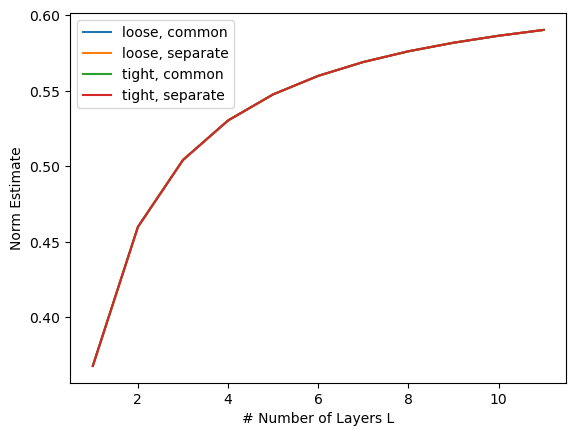

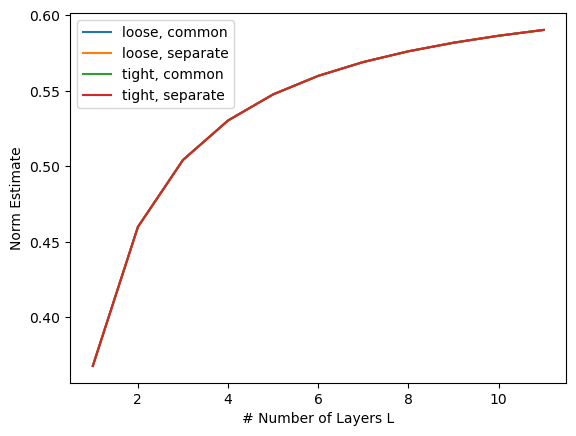

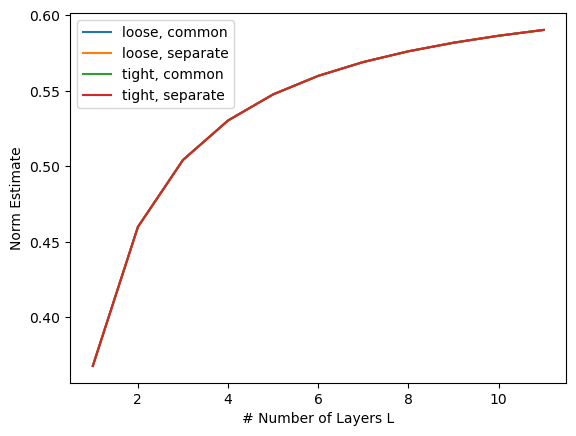

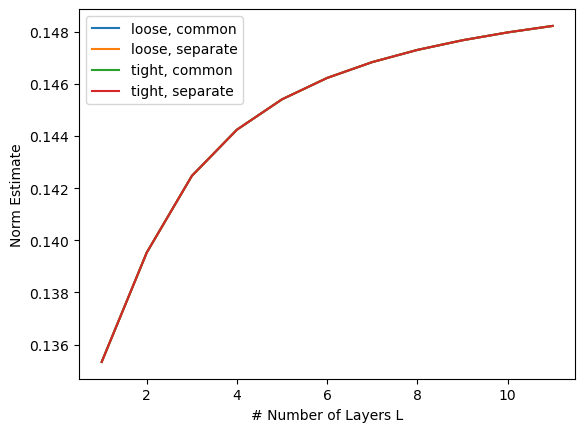

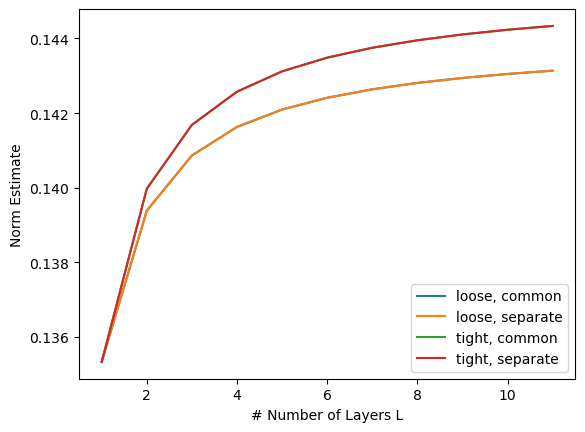

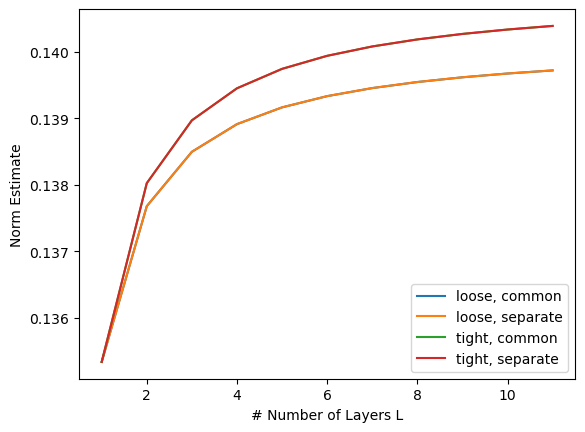

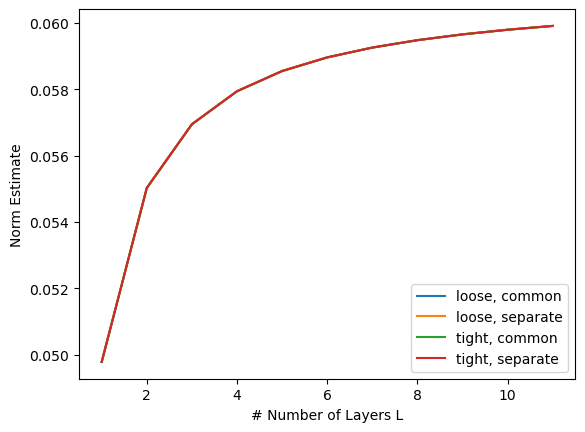

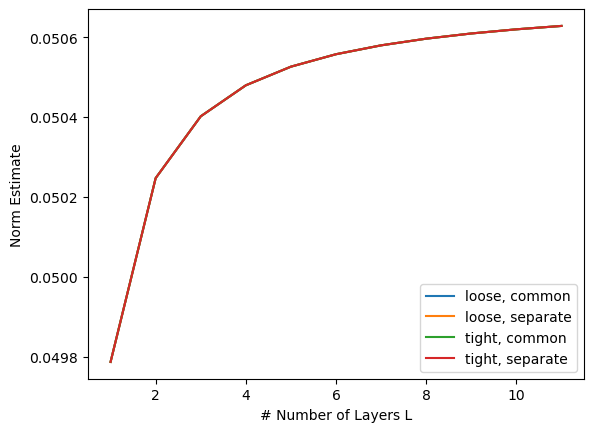

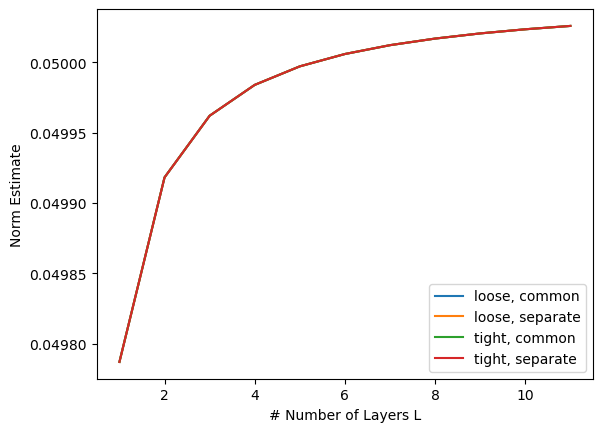

In [8]:
Lmax = 11
strategies = {
    "k": [k for k in range(1, 4)],
    "d": [1, 5, 10]
}

for strat in product_grid(strategies):
    k, d = itemgetter("k", "d")(strat)
    
    L = range(1, Lmax+1)
    plt.figure()
    for (proj_estimate, proj_strategy) in projection_list:
        curve = [
            deterministic_norm_estimate(l, d, k, proj_estimate, proj_strategy) for l in L
        ]
        plt.plot(L, curve, label=f"{proj_estimate}, {proj_strategy}")
    plt.ylabel("Norm Estimate")
    plt.xlabel("# Number of Layers L")
    plt.legend()
    plt.savefig(figpath / f"strategies-layers-norm-estimates-k_{k}-d{d}.png")
    plt.show()

### Projection strategies and width $d$ 

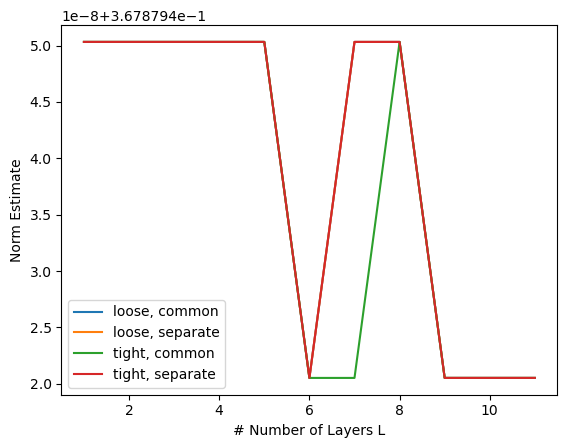

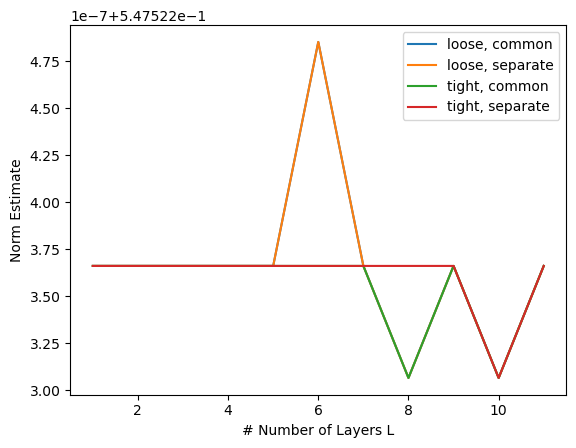

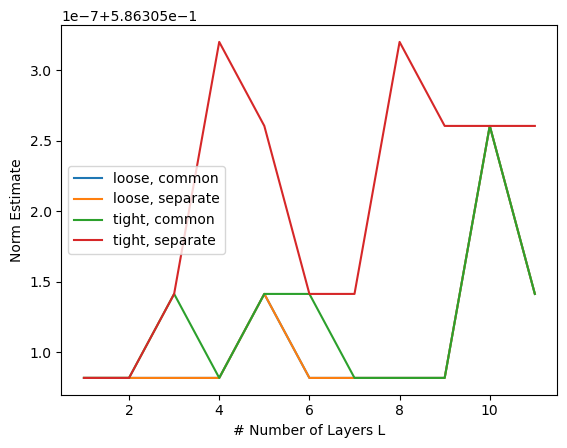

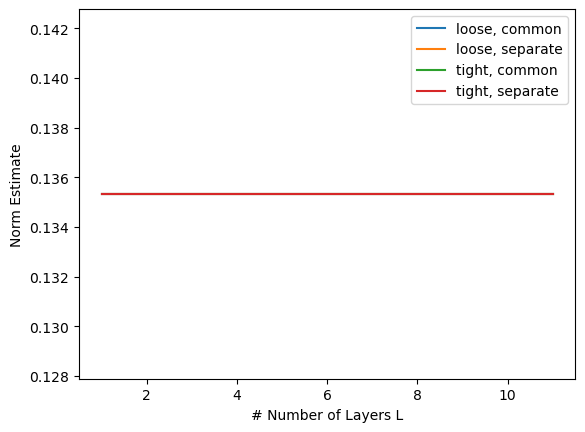

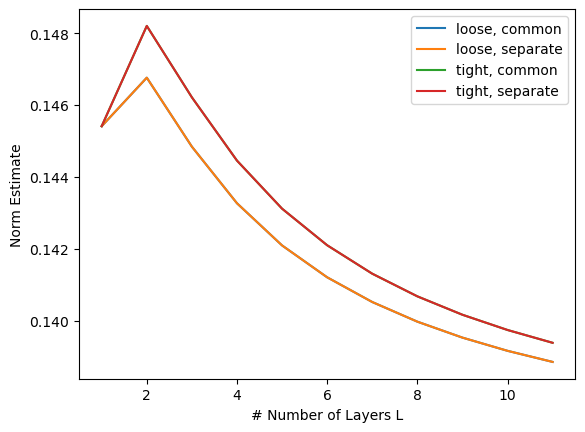

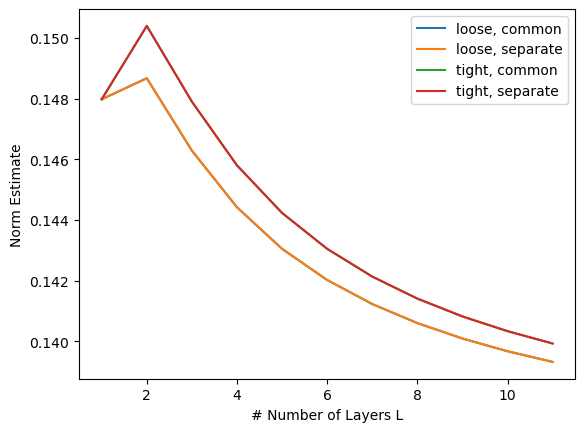

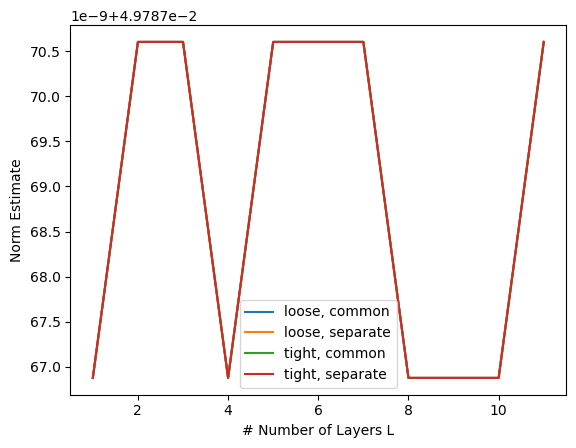

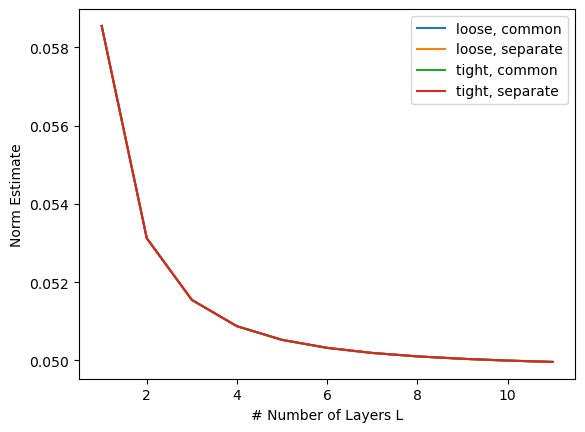

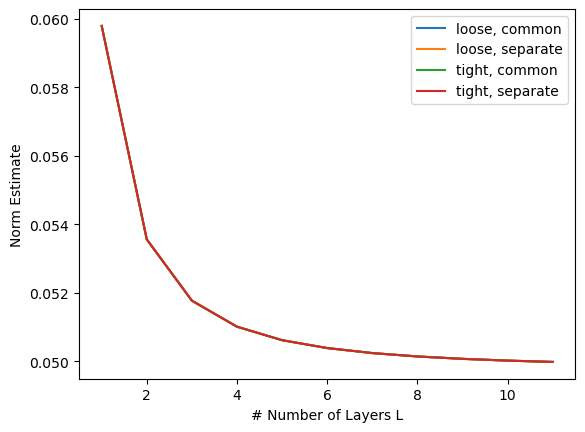

In [9]:
dmax = 11
strategies = {
    "k": [k for k in range(1, 4)],
    "L": [1, 5, 10]
}

for strat in product_grid(strategies):
    k, L = itemgetter("k", "L")(strat)
    
    d = range(1, dmax+1)
    plt.figure()
    for (proj_estimate, proj_strategy) in projection_list:
        curve = [
            deterministic_norm_estimate(L, di, k, proj_estimate, proj_strategy) for di in d
        ]
        plt.plot(d, curve, label=f"{proj_estimate}, {proj_strategy}")
    plt.ylabel("Norm Estimate")
    plt.xlabel("# Number of Layers L")
    plt.legend()
    plt.savefig(figpath / f"strategies-width-norm-estimates-k_{k}-L_{L}.png")
    plt.show()

### Projection strategies and order $k$

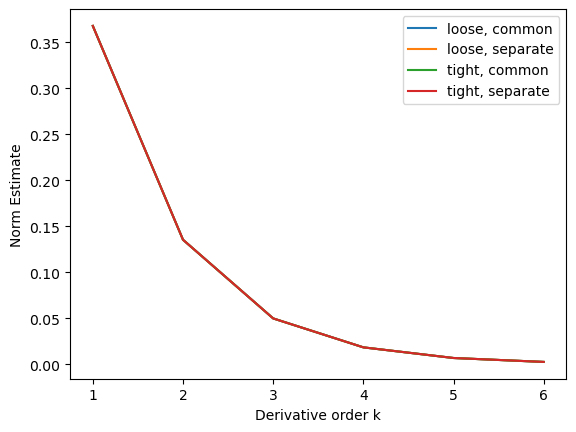

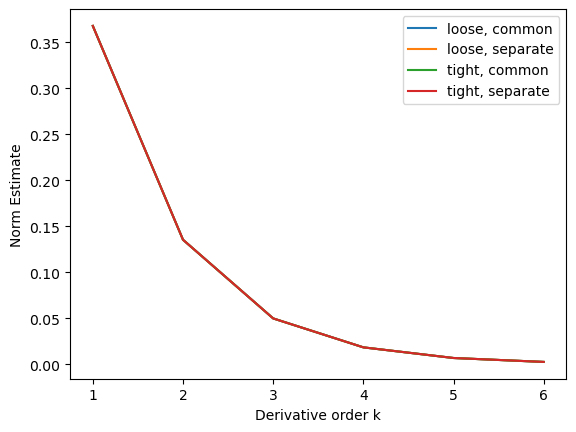

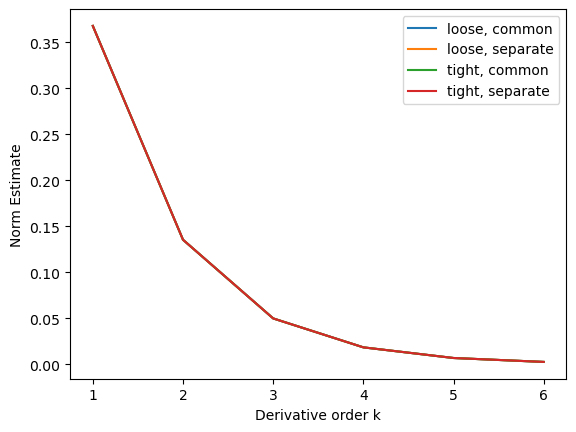

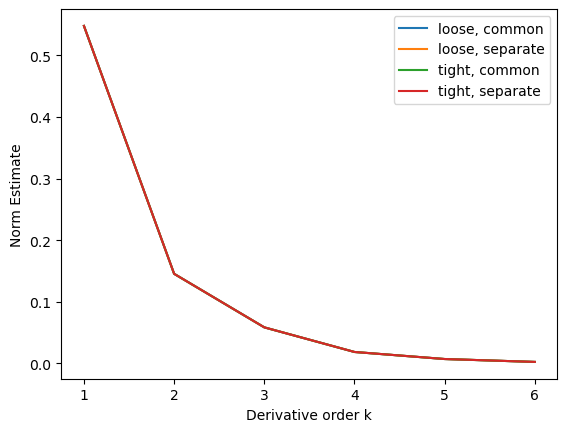

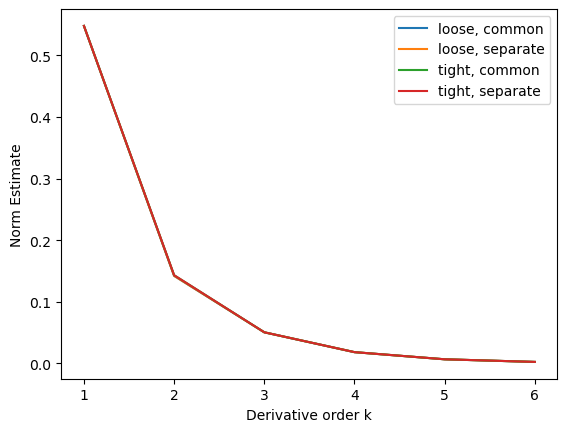

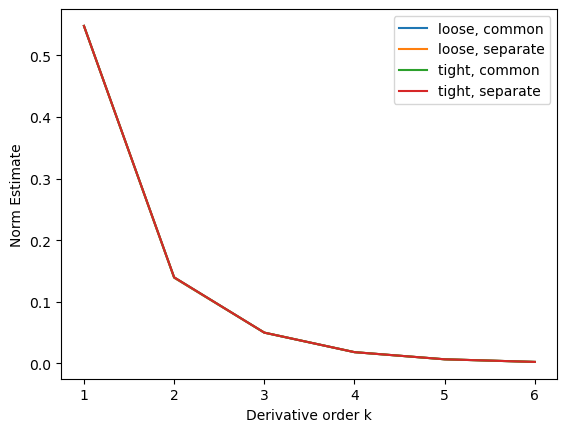

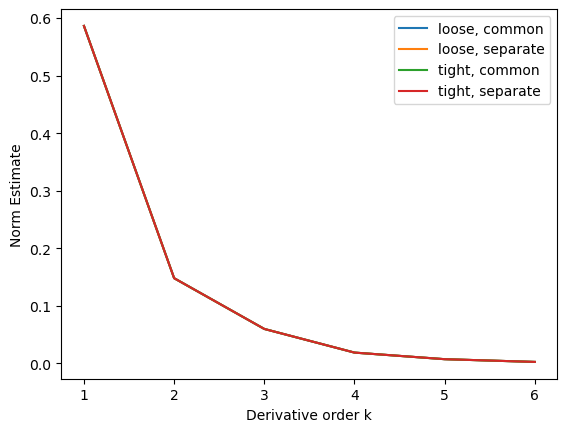

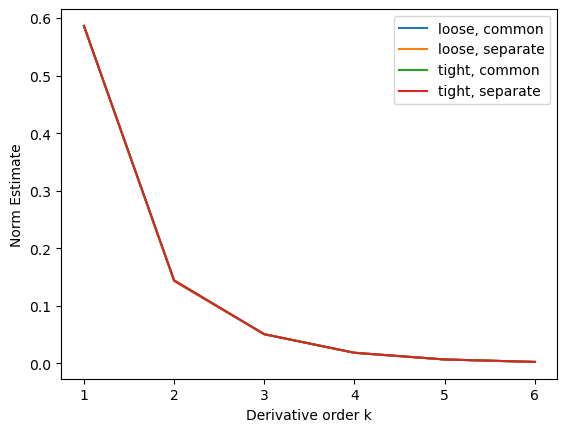

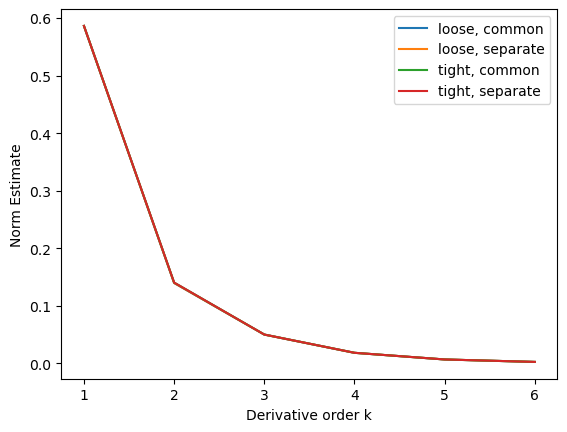

In [10]:
kmax = 6
strategies = {
    "L": [1, 5, 10],
    "d": [1, 5, 10]
}

for strat in product_grid(strategies):
    L, d = itemgetter("L", "d")(strat)
    
    k = range(1, kmax+1)
    plt.figure()
    for (proj_estimate, proj_strategy) in projection_list:
        curve = [
            deterministic_norm_estimate(L, d, ki, proj_estimate, proj_strategy) for ki in k
        ]
        plt.plot(k, curve, label=f"{proj_estimate}, {proj_strategy}")
    plt.ylabel("Norm Estimate")
    plt.xlabel("Derivative order k")
    plt.legend()
    plt.savefig(figpath / f"strategies-order-norm-estimates-L_{L}-d_{d}.png")
    plt.show()

### Varying depth L

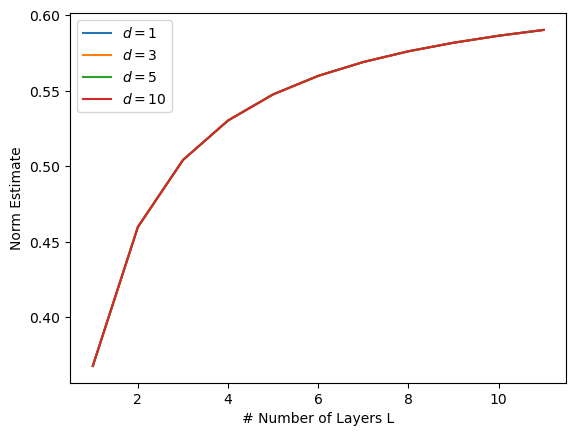

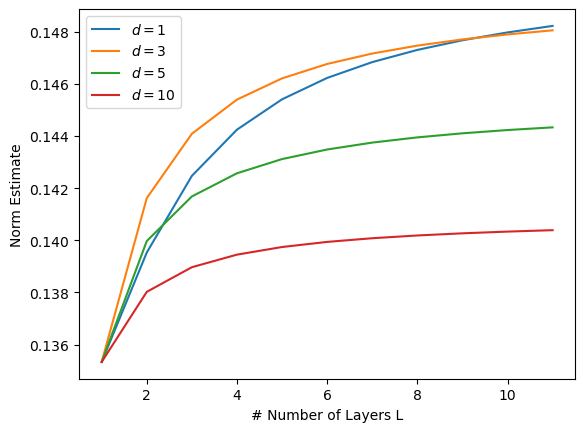

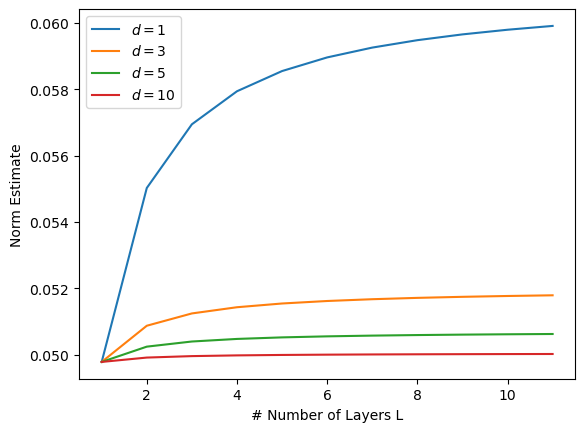

In [11]:
strategies = {
    "k": [k for k in range(1, 4)],
    "projection_norm_estimate": ["tight"],
    "projection_scale_strategy": ["common"]
}

for strat in product_grid(strategies):
    dvec = [1, 3, 5, 10]
    k, projection_norm_estimate, projection_scale_strategy = itemgetter("k", "projection_norm_estimate", "projection_scale_strategy")(strat)

    Lmax = 11
    L = range(1, Lmax+1)
    plt.figure()
    for di in dvec:
        curve = [
            deterministic_norm_estimate(l, di, k, projection_norm_estimate, projection_scale_strategy) for l in L
        ]
        plt.plot(L, curve, label=f"$d={di}$")
    plt.ylabel("Norm Estimate")
    plt.xlabel("# Number of Layers L")
    plt.legend()
    plt.savefig(figpath / f"layers-norm-estimates-k_{k}-{projection_norm_estimate}-{projection_scale_strategy}.png")
    plt.show()

In [ ]:
### Width $d$

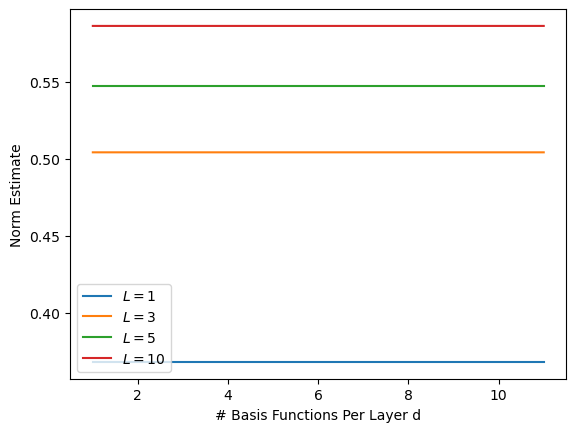

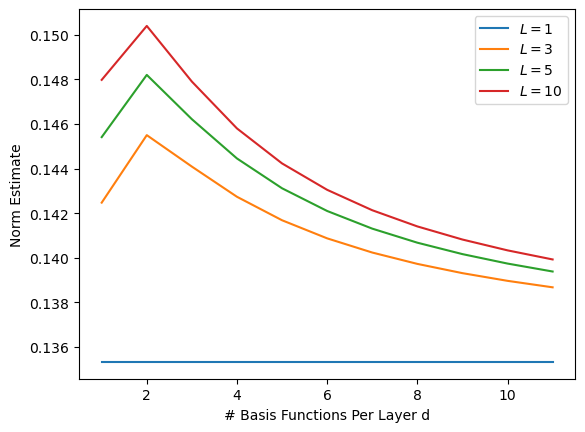

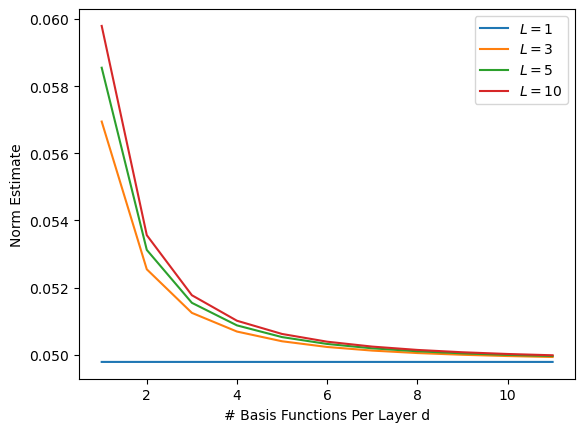

In [12]:
dmax = 11
strategies = {
    "k": [k for k in range(1, 4)],
    "projection_norm_estimate": ["tight"],
    "projection_scale_strategy": ["common"]
}

for strat in product_grid(strategies):
    L = [1, 3, 5, 10]
    k, projection_norm_estimate, projection_scale_strategy = itemgetter("k", "projection_norm_estimate", "projection_scale_strategy")(strat)

    dmax = 11
    d = range(1, dmax+1)
    plt.figure()
    for l in L:
        curve = [
            deterministic_norm_estimate(l, di, k, projection_norm_estimate, projection_scale_strategy) for di in d
        ] 
        plt.plot(d, curve, label=f"$L={l}$")

    plt.ylabel("Norm Estimate")
    plt.xlabel("# Basis Functions Per Layer d")
    plt.legend()
    plt.savefig(figpath / f"width-norm-estimates-k_{k}-{projection_norm_estimate}-{projection_scale_strategy}.png")
    plt.show()

## Normal Sampling 

In [16]:
def random_norm_estimate(L, d, k, projection_norm_estimate, projection_scale_strategy, runs):
    return mean([norm_estimate(torch.randn(L, d), k, projection_norm_estimate, projection_scale_strategy) 
                 for _ in range(runs)])

runs=100

### Different Projection Strategies

**Remarks based on results below**:

**Conclusion**:

In [17]:
projection_list = [('loose', 'common'), ('loose', 'separate'), ('tight', 'common'), ('tight', 'separate')]

#### Projection strategy and depth L

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

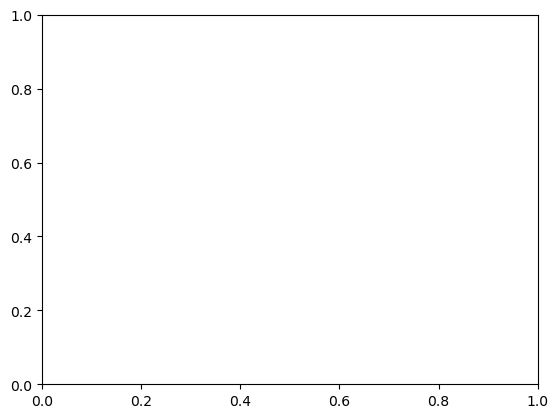

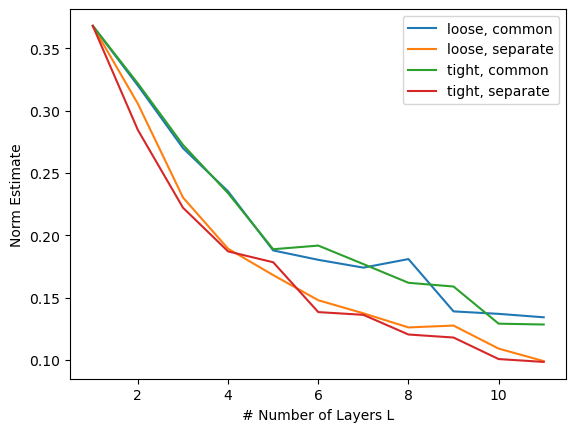

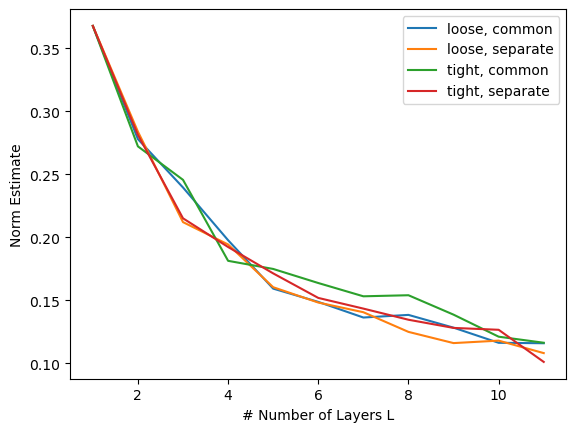

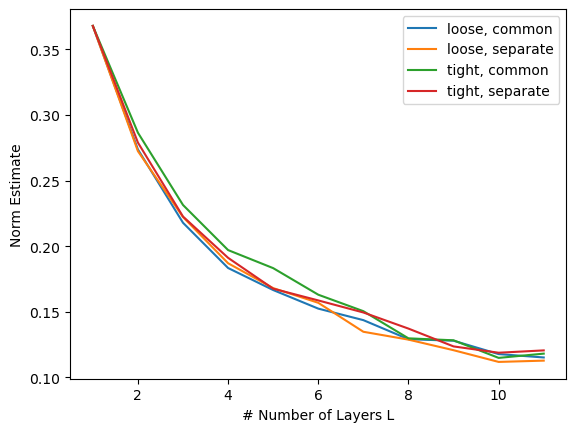

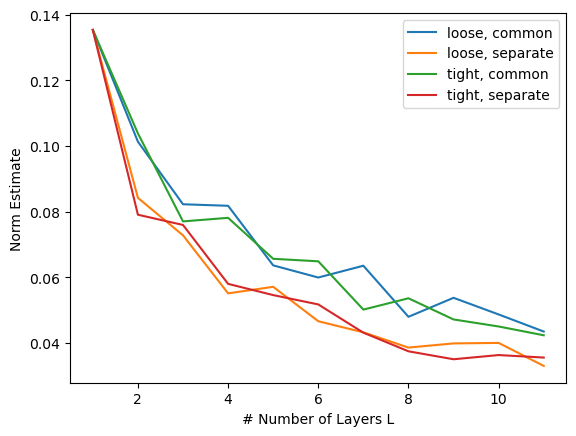

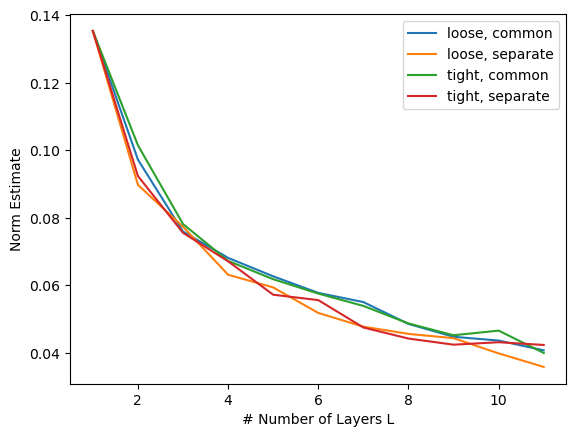

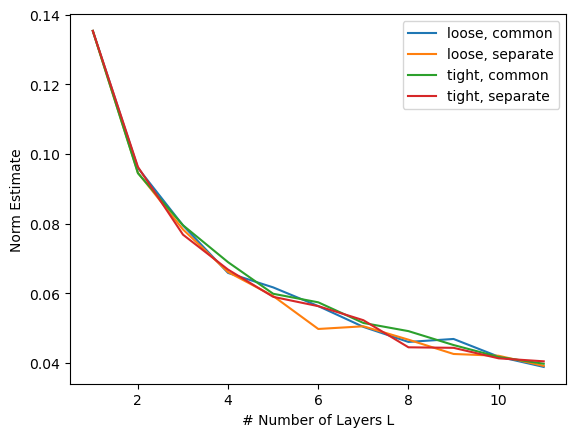

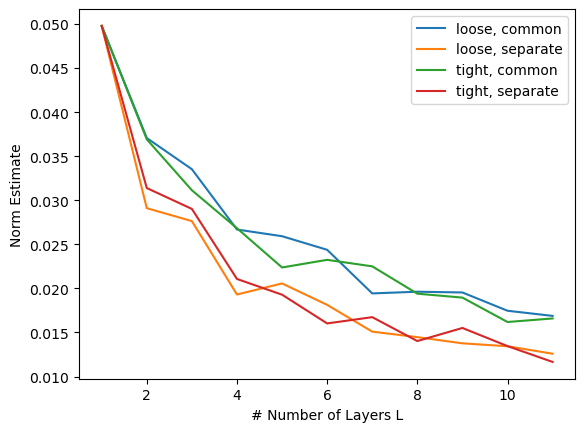

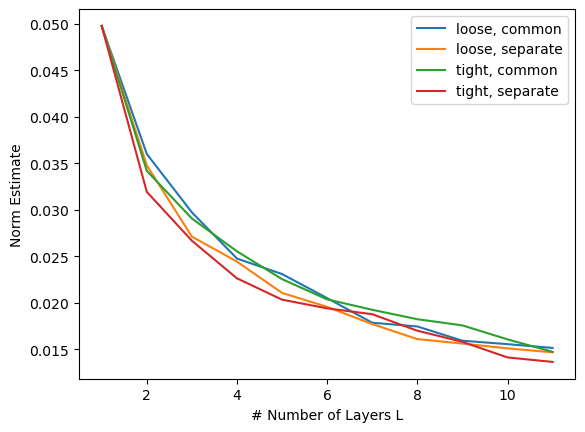

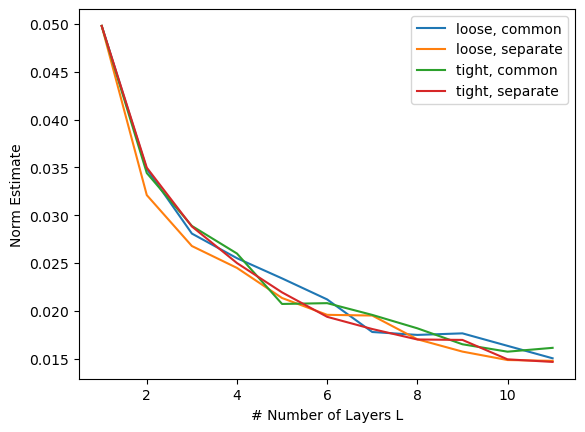

In [18]:
Lmax = 11
strategies = {
    "k": [k for k in range(1, 4)],
    "d": [1, 5, 10]
}

for strat in product_grid(strategies):
    k, d = itemgetter("k", "d")(strat)
    
    L = range(1, Lmax+1)
    plt.figure()
    for (proj_estimate, proj_strategy) in projection_list:
        curve = [
            random_norm_estimate(l, d, k, proj_estimate, proj_strategy, runs=runs) for l in L
        ]
        plt.plot(L, curve, label=f"{proj_estimate}, {proj_strategy}")
    plt.ylabel("Norm Estimate")
    plt.xlabel("# Number of Layers L")
    plt.legend()
    plt.savefig(figpath / f"random-strategies-layers-norm-estimates-k_{k}-d{d}-runs{runs}.png")
    plt.show()

### Projection strategies and width $d$ 

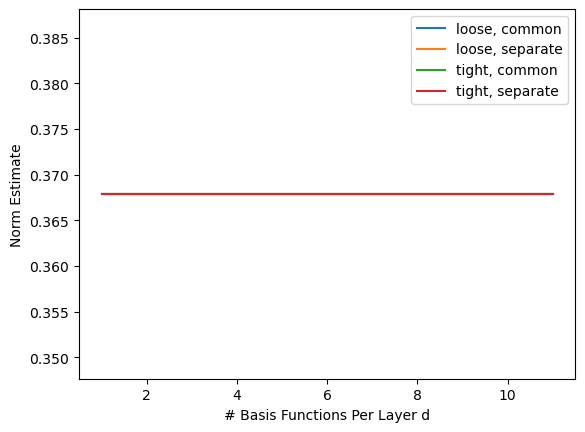

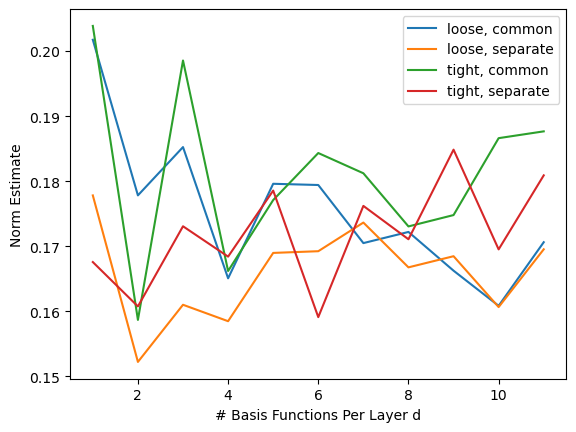

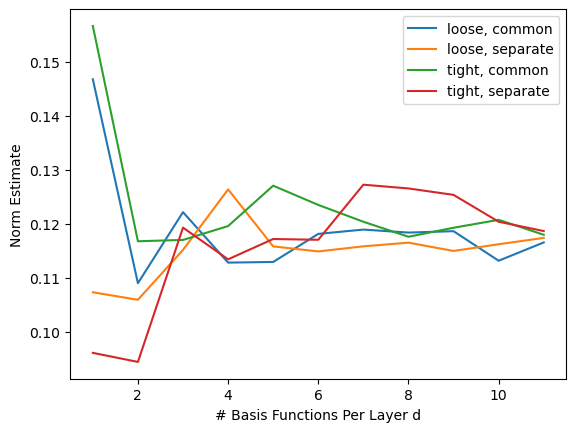

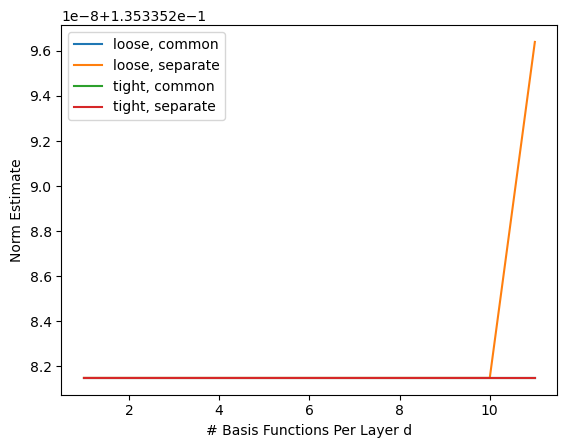

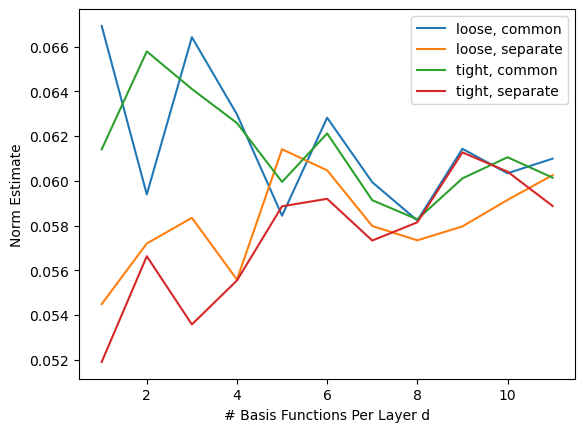

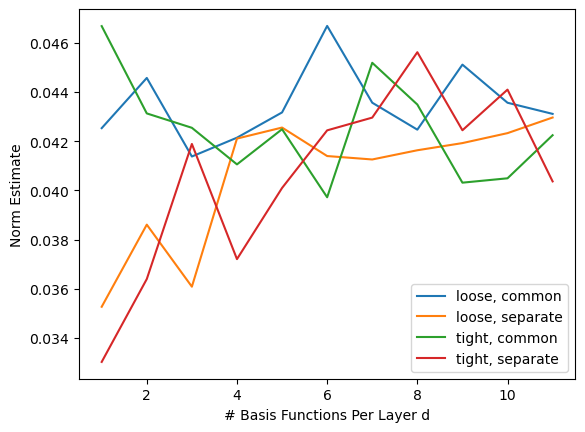

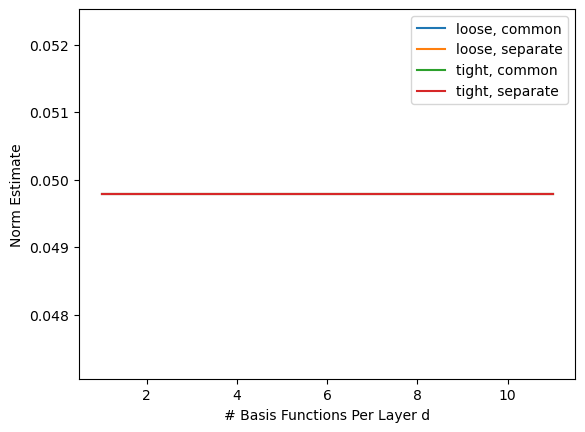

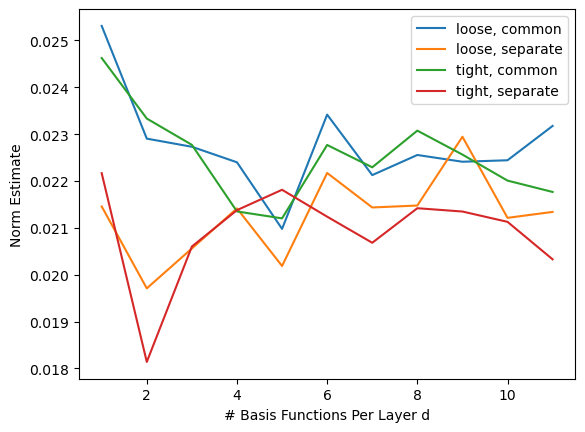

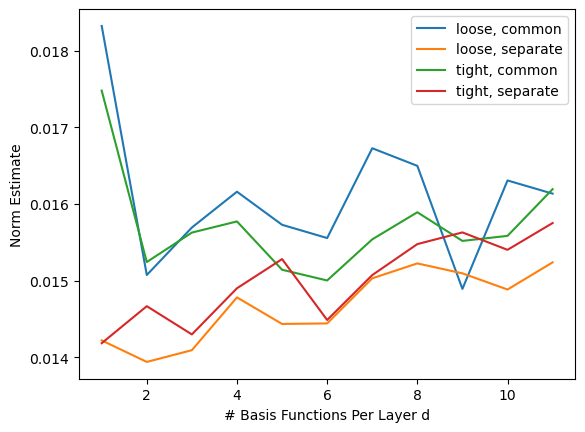

In [19]:
dmax = 11
strategies = {
    "k": [k for k in range(1, 4)],
    "L": [1, 5, 10]
}

for strat in product_grid(strategies):
    k, L = itemgetter("k", "L")(strat)
    
    d = range(1, dmax+1)
    plt.figure()
    for (proj_estimate, proj_strategy) in projection_list:
        curve = [
            random_norm_estimate(L, di, k, proj_estimate, proj_strategy, runs=runs) for di in d
        ]
        plt.plot(d, curve, label=f"{proj_estimate}, {proj_strategy}")
    plt.ylabel("Norm Estimate")
    plt.xlabel("# Basis Functions Per Layer d")
    plt.legend()
    plt.savefig(figpath / f"random-strategies-width-norm-estimates-k_{k}-L_{L}-runs{runs}.png")
    plt.show()

### Projection strategies and order $k$

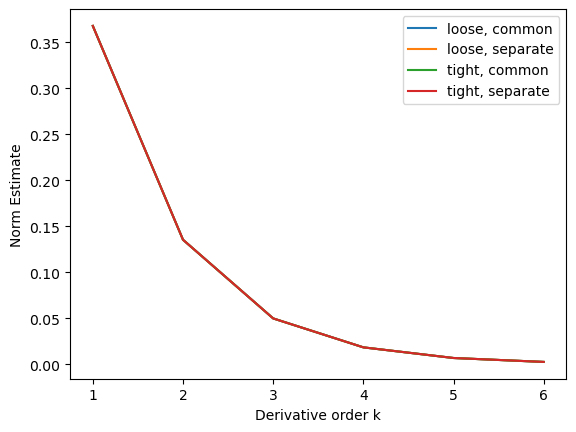

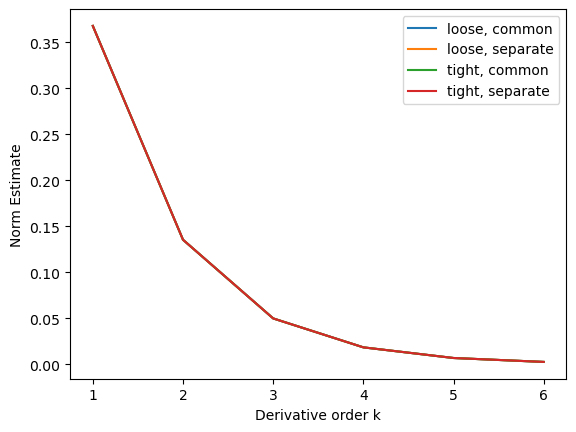

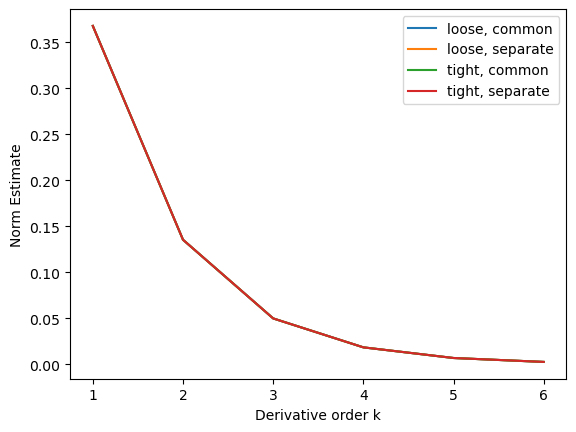

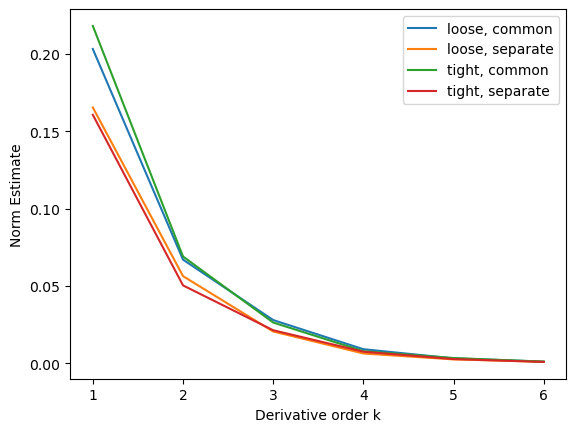

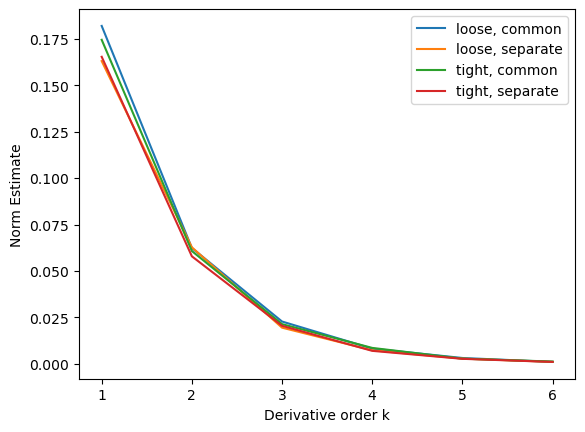

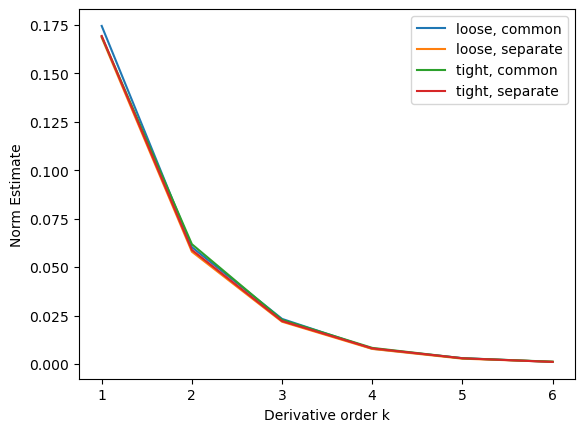

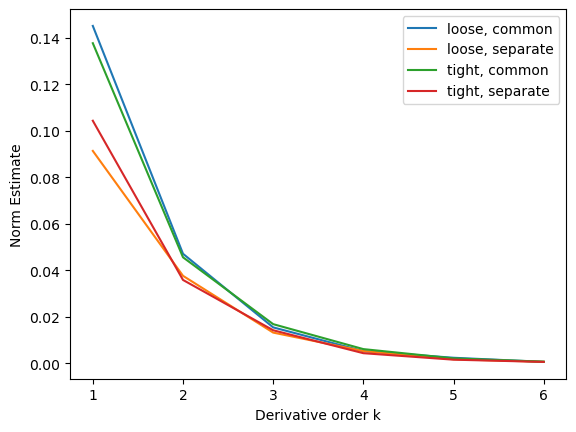

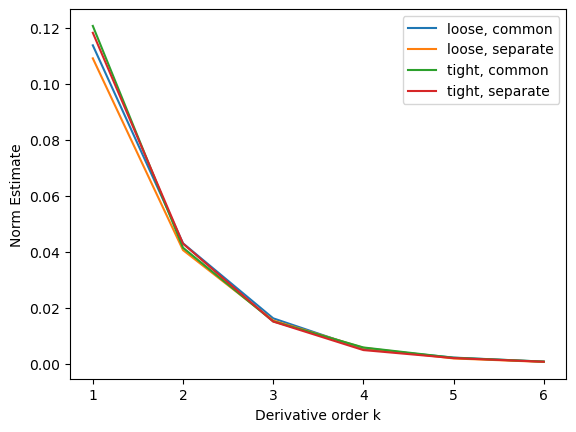

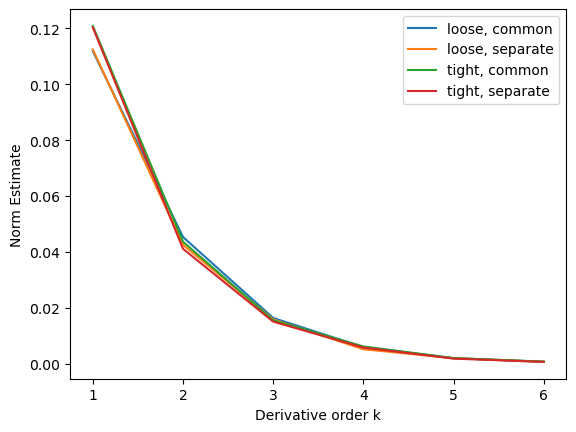

In [20]:
kmax = 6
strategies = {
    "L": [1, 5, 10],
    "d": [1, 5, 10]
}

for strat in product_grid(strategies):
    L, d = itemgetter("L", "d")(strat)
    
    k = range(1, kmax+1)
    plt.figure()
    for (proj_estimate, proj_strategy) in projection_list:
        curve = [random_norm_estimate(L, d, ki, proj_estimate, proj_strategy, runs=runs) for ki in k]
        plt.plot(k, curve, label=f"{proj_estimate}, {proj_strategy}")
    plt.ylabel("Norm Estimate")
    plt.xlabel("Derivative order k")
    plt.legend()
    plt.savefig(figpath / f"random-strategies-order-norm-estimates-L_{L}-d_{d}-runs{runs}.png")
    plt.show()

### Missing Figures
1. Comparison of norm estimates vs. derivative order for different L
1. Comparison of norm estimates vs. derivative order for different d

<Figure size 640x480 with 0 Axes>

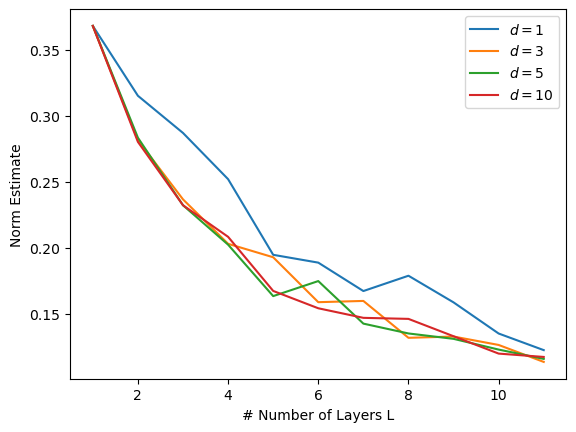

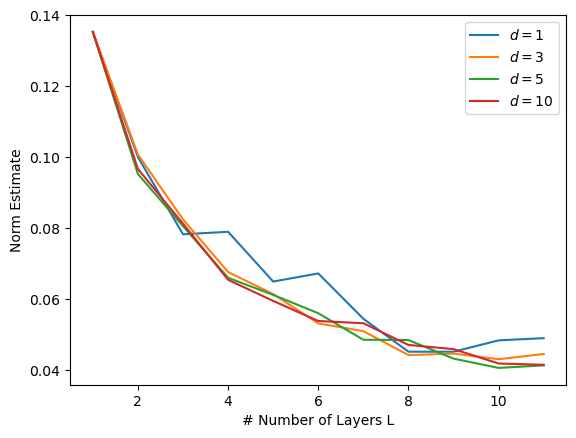

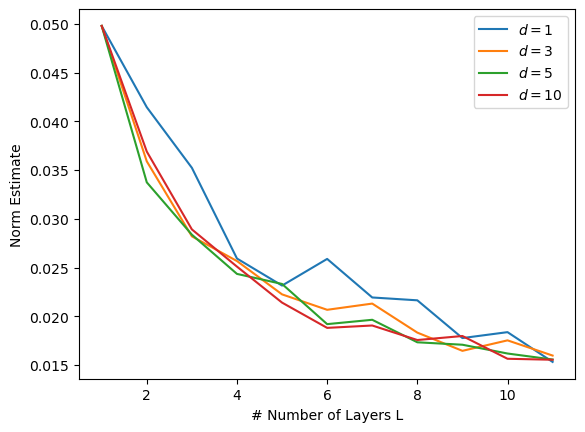

In [24]:
strategies = {
    "k": [k for k in range(1, 4)],
    "projection_norm_estimate": ["tight"],
    "projection_scale_strategy": ["common"]
}

for strat in product_grid(strategies):
    dvec = [1, 3, 5, 10]
    k, projection_norm_estimate, projection_scale_strategy = itemgetter("k", "projection_norm_estimate", "projection_scale_strategy")(strat)

    Lmax = 11
    L = range(1, Lmax+1)
    plt.figure()
    for di in dvec:
        curve = [
            random_norm_estimate(l, di, k, projection_norm_estimate, projection_scale_strategy, runs) for l in L
        ]
        plt.plot(L, curve, label=f"$d={di}$")
    plt.ylabel("Norm Estimate")
    plt.xlabel("# Number of Layers L")
    plt.legend()
    plt.savefig(figpath / f"random-layers-k_{k}-{projection_norm_estimate}-{projection_scale_strategy}-runs{runs}.png")
    plt.show()

### Width $d$

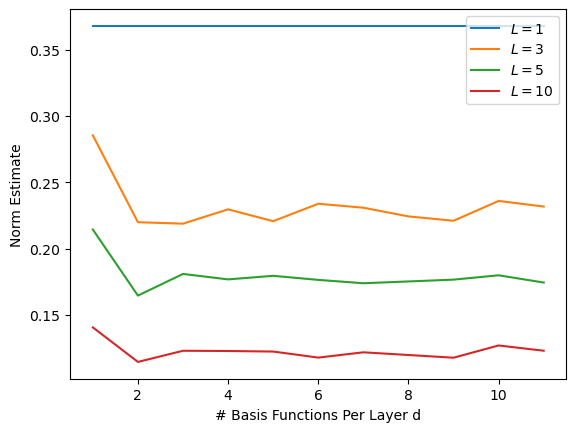

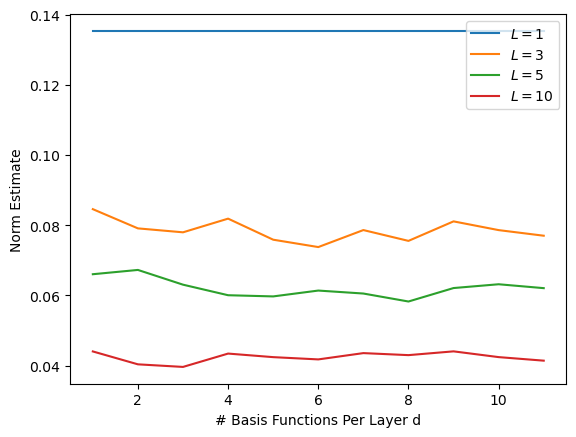

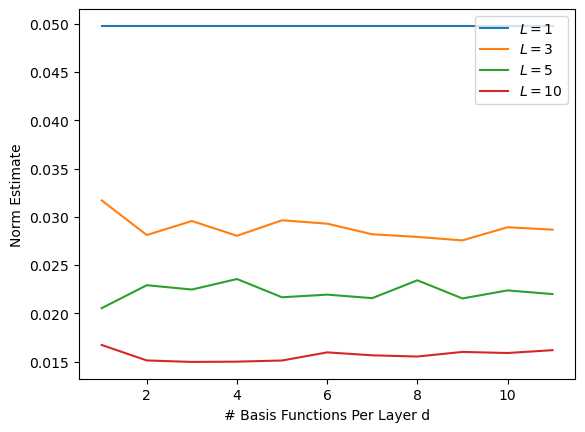

In [25]:
dmax = 11
strategies = {
    "k": [k for k in range(1, 4)],
    "projection_norm_estimate": ["tight"],
    "projection_scale_strategy": ["common"]
}

for strat in product_grid(strategies):
    L = [1, 3, 5, 10]
    k, projection_norm_estimate, projection_scale_strategy = itemgetter("k", "projection_norm_estimate", "projection_scale_strategy")(strat)

    dmax = 11
    d = range(1, dmax+1)
    plt.figure()
    for l in L:
        curve = [
            random_norm_estimate(l, di, k, projection_norm_estimate, projection_scale_strategy, runs) for di in d
        ] 
        plt.plot(d, curve, label=f"$L={l}$")

    plt.ylabel("Norm Estimate")
    plt.xlabel("# Basis Functions Per Layer d")
    plt.legend()
    plt.savefig(figpath / f"random-width-k_{k}-{projection_norm_estimate}-{projection_scale_strategy}-runs{runs}.png")
    plt.show()